**Business Problem Statement** - The core challenge for this online retail company is the management of its inventory effectively. The company currently struggles with sales revenue fluctuations, which consequently lead to difficulty to predict demand accurately. This leads to two(2) issues:

1. Overstocking: This is when sales are lower than anticipated, bringing about excess inventory. This leads to capital being tied up, increased storage cost which eventually lead to product obsolence and write-offs in some cases.
2. Understocking: This on the other hand deals with when sales exceed expectations. Here, the company faces stockouts.This results in lost sales opportunities, dissatisfied customers who cannot purchase items they desire, and potential damage to the company's reputation.


The aim is to develop a reliable predictive model that can forecast future sales revenue based on historical sales data, customer information and other relevant features as input to predict the toatal sales revenue for a future sales period (eg. the next day, week, or, month). The output of this model will be a numerical value representing the expected sales revenue.
This model will address the business problem by enabling optimized stock levels, reducing operational costs and enhancing customer satisfaction overall.

URL for the dataset - https://www.kaggle.com/datasets/thedevastator/online-retail-sales-and-customer-data

The data consists of sales and customer data. It contains relevant information such as **Description of items, Quantity, Invoice Date, Unit Price and Country**

The business problem can be formulated as a regression machine learning task. The goal is to predict a continuous numerical value: **future sales revenue**.

Considering that the aim is to predict sales revenue, the target variable will be **SalesRevenue** and this can be calculated as **Quantity** * **UnitPrice**.
SalesRevenue will then aggregrated to a daily, weekly and monthly level for time-series forecasting.

Also considering that this is a time-series regression which aims at reducing overstocking and understocking, these metrics are applied:

**Mean Absolute Error (MAE)** - This simply measures the magnitude of errors. It is useful for understanding the direct monetary impact of errors in forecasting.

**Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)** - MSE highlights larger errors than smaller ones because of the squaring. RMSE is the square root of MSE and is easier to interpret because it is in the same units as the target variable. Due to RMSE being great for highlighting the impact of large errors, it is helpful for showing over or understocking.

**R-squared (Coefficient of Determination)** - This is a portion of the variance in the dependent variable that is predictable from independent variables. It shows how well the model fits the data, but when dealing with forecasts on future events, it is less informative than error-based metrics such as MAE and RMSE.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

The dataset is loaded and the first five(5) rows are shown

In [ ]:
df = pd.read_csv('online_retail.csv')
df.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Brief summary of the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   index        541909 non-null  int64  
 1   InvoiceNo    541909 non-null  object 
 2   StockCode    541909 non-null  object 
 3   Description  540455 non-null  object 
 4   Quantity     541909 non-null  int64  
 5   InvoiceDate  541909 non-null  object 
 6   UnitPrice    541909 non-null  float64
 7   CustomerID   406829 non-null  float64
 8   Country      541909 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 37.2+ MB


Descriptive statistics of the numerical colums

In [ ]:
df.describe()

,index,Quantity,UnitPrice,CustomerID
count,541909.00000,541909.000000,541909.000000,406829.000000
mean,270954.00000,9.552250,4.611114,15287.690570
std,156435.79785,218.081158,96.759853,1713.600303
min,0.00000,-80995.000000,-11062.060000,12346.000000
25%,135477.00000,1.000000,1.250000,13953.000000
50%,270954.00000,3.000000,2.080000,15152.000000
75%,406431.00000,10.000000,4.130000,16791.000000
max,541908.00000,80995.000000,38970.000000,18287.000000


Identification of missing values in each column displayed here

In [ ]:
df.isnull().sum()

,0
index,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


**Data Preprocessing and Feature Engineering**

Removing rows with missing CustomerID because it is important for customer-level analysis that will be performed later

In [ ]:
df.dropna(subset=['CustomerID'], inplace=True)

Removing rows with missing Description because it is not used directly in the calculation of sales revenue

In [ ]:
df.dropna(subset=['Description'], inplace=True)

Removing rows where Quantity and/or UnitPrice is less than or equal to 0

In [ ]:
df = df[df['Quantity'] > 0]

In [ ]:
df = df[df['UnitPrice'] > 0]

Creating a new column 'SalesRevenue'

In [ ]:
df['SalesRevenue'] = df['Quantity'] * df['UnitPrice']

Converting the 'InvoiceDate' column to a datetime object

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

Aggregrating the data to a daily frequency

In [ ]:
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['SalesRevenue'].sum().reset_index()
daily_sales.rename(columns={'InvoiceDate': 'Date'}, inplace=True)

Visualization using Line Plot to show Daily Sales Revenue Over Time

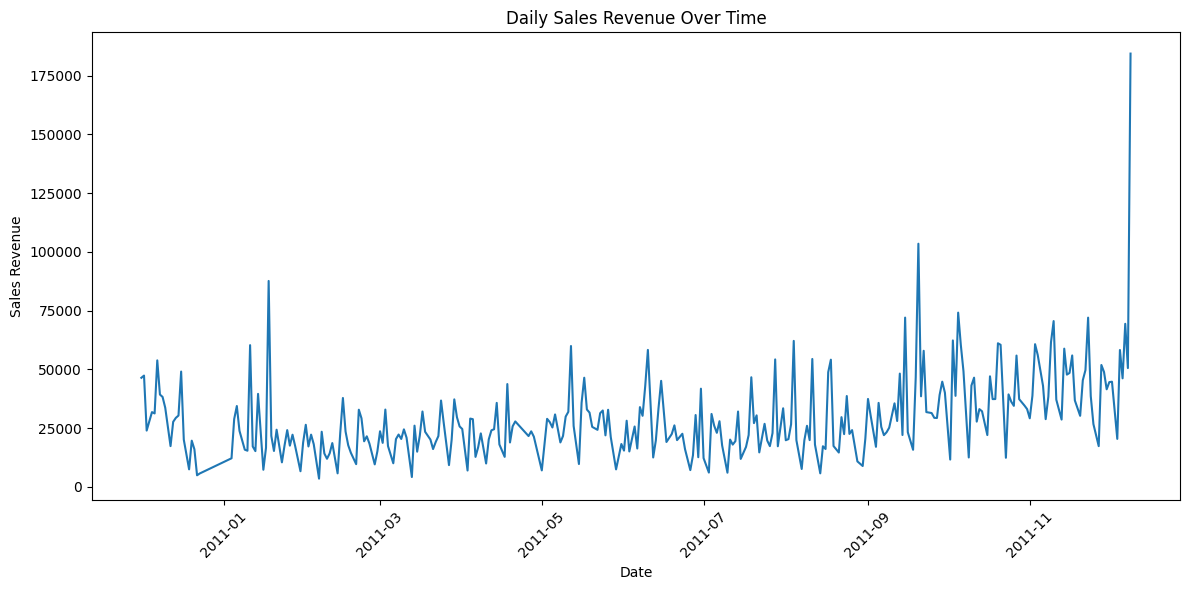

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_sales, x='Date', y='SalesRevenue')
plt.title('Daily Sales Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Converting the Date column back to DateTime object after aggregration

In [ ]:
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])

Showing the first five(5) rows of the daily aggregrated data

In [ ]:
daily_sales.head()

,Date,SalesRevenue
0,2010-12-01,46376.49
1,2010-12-02,47316.53
2,2010-12-03,23921.71
3,2010-12-05,31771.60
4,2010-12-06,31215.64


Information on the daily aggregrated data

In [ ]:
daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          305 non-null    datetime64[ns]
 1   SalesRevenue  305 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.9 KB


**Creation of Lag and Moving Average Features**

In [ ]:
daily_sales = daily_sales.sort_values(by='Date')

Creating lag features for SalesRevenue - Lag 1, 7, and 30 days

In [ ]:
# Lag 1 - SalesRevenue from the previous day
daily_sales['SalesRevenueLag1'] = daily_sales['SalesRevenue'].shift(1)
# Lag 2 - SalesRevenue from the previous week(7 days)
daily_sales['SalesRevenueLag2'] = daily_sales['SalesRevenue'].shift(7)
# Lag 3 - SalesRevenue from the previous month(30 days)
daily_sales['SalesRevenueLag3'] = daily_sales['SalesRevenue'].shift(30)

Moving Averages for SalesRevenue - 7-day and 30-day moving average

In [ ]:
# 7-day moving average
daily_sales['SalesRevenueMA7'] = daily_sales['SalesRevenue'].rolling(window=7).mean()
# 30-day moving average
daily_sales['SalesRevenueMA30'] = daily_sales['SalesRevenue'].rolling(window=30).mean()

The first five(5) row with the new features

In [ ]:
daily_sales.head()

,Date,SalesRevenue,SalesRevenueLag1,SalesRevenueLag2,SalesRevenueLag3,SalesRevenueMA7,SalesRevenueMA30
0,2010-12-01,46376.49,NaN,NaN,NaN,NaN,NaN
1,2010-12-02,47316.53,46376.49,NaN,NaN,NaN,NaN
2,2010-12-03,23921.71,47316.53,NaN,NaN,NaN,NaN
3,2010-12-05,31771.60,23921.71,NaN,NaN,NaN,NaN
4,2010-12-06,31215.64,31771.60,NaN,NaN,NaN,NaN


Daily sales revenue information showing lag and moving average features

In [ ]:
daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              305 non-null    datetime64[ns]
 1   SalesRevenue      305 non-null    float64       
 2   SalesRevenueLag1  304 non-null    float64       
 3   SalesRevenueLag2  298 non-null    float64       
 4   SalesRevenueLag3  275 non-null    float64       
 5   SalesRevenueMA7   299 non-null    float64       
 6   SalesRevenueMA30  276 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 16.8 KB


Due to the application of lag and moving average features, there are now missing values. These missing values must be addressed and also consider outlier handling on the 'SalesRevenue' and newly created features

In [ ]:
daily_sales.dropna(inplace=True)

Before considering outlier handling, the data must be inspected by means of visualization using box plot


Checking for outliers in SalesRevenue and newly created features:


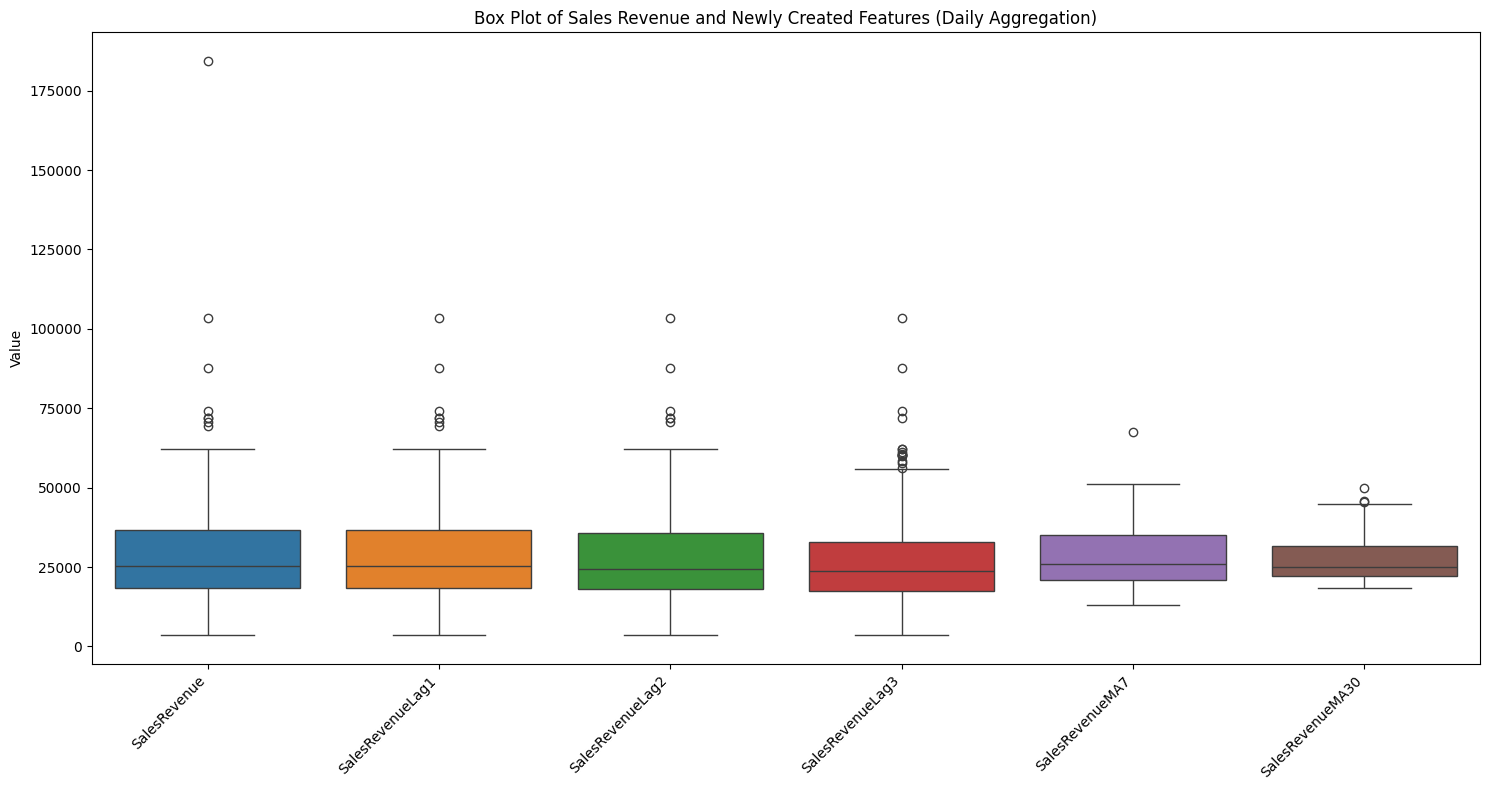

In [ ]:
print("\nChecking for outliers in SalesRevenue and newly created features:")
numerical_cols = ['SalesRevenue', 'SalesRevenueLag1', 'SalesRevenueLag2', 'SalesRevenueLag3', 'SalesRevenueMA7', 'SalesRevenueMA30']
plt.figure(figsize=(15, 8))
sns.boxplot(data=daily_sales[numerical_cols])
plt.title('Box Plot of Sales Revenue and Newly Created Features (Daily Aggregation)')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

After visualization, descriptive statistics after handling missing values and before specific outlier treatment

In [ ]:
cols_for_describe = ['SalesRevenue', 'SalesRevenueLag1', 'SalesRevenueLag2', 'SalesRevenueLag3', 'SalesRevenueMA7', 'SalesRevenueMA30']
daily_sales[cols_for_describe].describe()

,SalesRevenue,SalesRevenueLag1,SalesRevenueLag2,SalesRevenueLag3,SalesRevenueMA7,SalesRevenueMA30
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,29368.566778,28841.958560,28326.348851,26967.405796,28692.006030,27786.864385
std,18203.583920,15614.367384,15381.243960,14610.317078,9719.353430,7843.771019
min,3457.110000,3457.110000,3457.110000,3457.110000,13067.504286,18437.480000
25%,18286.170000,18286.170000,17959.180000,17415.205000,20887.361429,22053.557667
50%,25232.670000,25232.670000,24431.720000,23631.870000,25964.144286,25010.766367
75%,36724.195000,36724.195000,35700.700000,32868.960000,35018.450857,31458.714833
max,184349.280000,103435.810000,103435.810000,103435.810000,67665.542857,49845.710333


Final check of the preprocessed daily sales data

In [ ]:
daily_sales.head()

,Date,SalesRevenue,SalesRevenueLag1,SalesRevenueLag2,SalesRevenueLag3,SalesRevenueMA7,SalesRevenueMA30
30,2011-01-16,7242.06,39532.02,23797.79,46376.49,24356.162857,26530.587000
31,2011-01-17,16597.35,7242.06,15778.20,47316.53,24473.184286,25506.614333
32,2011-01-18,87589.11,16597.35,15346.83,23921.71,34793.510000,27628.861000
33,2011-01-19,21646.78,87589.11,60268.78,31771.60,29276.081429,27291.367000
34,2011-01-20,15244.73,21646.78,17153.94,31215.64,29003.337143,26759.003333


In [ ]:
daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275 entries, 30 to 304
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              275 non-null    datetime64[ns]
 1   SalesRevenue      275 non-null    float64       
 2   SalesRevenueLag1  275 non-null    float64       
 3   SalesRevenueLag2  275 non-null    float64       
 4   SalesRevenueLag3  275 non-null    float64       
 5   SalesRevenueMA7   275 non-null    float64       
 6   SalesRevenueMA30  275 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 17.2 KB


Model Selection and Training

daily_sales will now be split into training and testing sets.

Using a time-based split, data from the last two months will be used as the test set.

The data is between 12/01/2010 to 12/09/2011

But first, the cutoff date will be set to 10/01/2011 in order to obtain a reasonable test size

In [ ]:
cutoff_date = pd.to_datetime('10/01/2011')

In [ ]:
train_df = daily_sales[daily_sales['Date'] < cutoff_date].copy()
test_df = daily_sales[daily_sales['Date'] >= cutoff_date].copy()

Defining features (X) and target (y)

In [ ]:
features = ['SalesRevenueLag1', 'SalesRevenueLag2', 'SalesRevenueLag3', 'SalesRevenueMA7', 'SalesRevenueMA30']
target = 'SalesRevenue'

In [ ]:
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

Dropping rows with NaN values from training and testing sets

In [ ]:
X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]

In [ ]:
print("Training Set Shape:", X_train.shape, y_train.shape)
print("Testing Set Shape:", X_test.shape, y_test.shape)

Training Set Shape: (215, 5) (215,)
Testing Set Shape: (60, 5) (60,)


Selection of a few regression models suitable for time-series forecasting

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
}

Dictionary to store evaluation results

In [ ]:
results = {}

Each selected model will be trained on the training data, predictions will be made and performance evaluated using MAE and RMSE

In [ ]:
for name, model in models.items():
  print(f"\nTraining {name}...")
  model.fit(X_train, y_train)

  print(f"Making predictions with {name}...")
  y_pred = model.predict(X_test)

  mae = mean_absolute_error(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))

  results[name] = {'MAE': mae, 'RMSE': rmse}
  print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")


Training Linear Regression...
Making predictions with Linear Regression...
Linear Regression - MAE: 12420.76, RMSE: 19343.81

Training Ridge Regression...
Making predictions with Ridge Regression...
Ridge Regression - MAE: 12420.76, RMSE: 19343.81

Training Lasso Regression...
Making predictions with Lasso Regression...
Lasso Regression - MAE: 12420.76, RMSE: 19343.81

Training Random Forest Regressor...
Making predictions with Random Forest Regressor...
Random Forest Regressor - MAE: 14051.15, RMSE: 21661.67

Training Gradient Boosting Regressor...
Making predictions with Gradient Boosting Regressor...
Gradient Boosting Regressor - MAE: 15065.84, RMSE: 21952.86


**Hyperparameter tuning of the selected model for performance optimization**

Defining the hyperparameter grid for Lasso Regression - alpha (regularization strength)

In [ ]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

Using neg_root_mean_squared_error as the scoring metric to align with RMSE minimization, GridSearchCV will be applied with the Lasso model, hyperparameter grid, and scoring metric

In [ ]:
grid_search = GridSearchCV(estimator=Lasso(random_state=42),
                           param_grid= param_grid,
                           scoring='neg_root_mean_squared_error',
                           cv=5,
                           n_jobs=-1)

Fitting the tuning object to the training data

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='neg_root_mean_squared_error')

Obtaining the best parameters and the best score

In [ ]:
best_alpha = grid_search.best_params_['alpha']
best_rmse_score = -grid_search.best_score_

print(f"Best hyperparameters found: {grid_search.best_params_}")
print(f"Best cross validation rmse: {best_rmse_score:.2f}")

Best hyperparameters found: {'alpha': 100}
Best cross validation rmse: 10554.02


Training the best model with the optimal hyperparameters on the whole training data

In [ ]:
tuned_lasso_model = Lasso(alpha=best_alpha, random_state=42)
tuned_lasso_model.fit(X_train, y_train)

Lasso(alpha=100, random_state=42)

Evaluating the performance of the tuned model on the test set

In [ ]:
y_pred_tuned = tuned_lasso_model.predict(X_test)

mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print(f"Tuned Lasso Performance on Test Set:")
print(f"MAE: {mae_tuned:2f}")
print(f"RMSE: {rmse_tuned:2f}")

Tuned Lasso Performance on Test Set:
MAE: 12420.703291
RMSE: 19343.758408


Comparing the performance of the tuned model with the performance of the default model

In [ ]:
default_lasso_mae = results['Lasso Regression']['MAE']
default_lasso_rmse = results['Lasso Regression']['RMSE']

print("\nPerformance Comparison (Tuned vs. Default Lasso):")
print(f"Default Lasso - MAE: {default_lasso_mae:.2f}, RMSE: {default_lasso_rmse:.2f}")
print(f"Tuned Lasso - MAE: {mae_tuned:.2f}, RMSE: {rmse_tuned:.2f}")


Performance Comparison (Tuned vs. Default Lasso):
Default Lasso - MAE: 12420.76, RMSE: 19343.81
Tuned Lasso - MAE: 12420.70, RMSE: 19343.76


**Model Assessment** - To evaluate the performance of the best model on other unknown test set using the chosen evaluation metrics.

MAE and RMSE will be used to evaluate the performance of the tuned Lasso model on the test set

In [ ]:
y_pred_tuned = tuned_lasso_model.predict(X_test)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print("Performance of the Tuned Lasso Model on the Test Set:")
print(f"Mean Absolute Error (MAE): {mae_tuned:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_tuned:.2f}")

Performance of the Tuned Lasso Model on the Test Set:
Mean Absolute Error (MAE): 12420.70
Root Mean Squared Error (RMSE): 19343.76


**FINAL DISCUSSION OF OVERALL PIPELINE**

Based on the machine learning pipeline developed for for forecasting daily sales revenue, the best performing model after hyperparameter tuning was the **Lasso Regression** model with an optimal 'alpha' of 100. The performance of the unknown test set was evaluated using MAE and RMSE.

**Strengths of the Developed Pipeline**
1. The machine learning pipeline provided a **clear and structured approach** from the definition of the problem to evaluation of the model.
2. **Identifying and dropping missing values** ensured that the data was clean for the model to be trained on.
3. **The use of lag features**(SalesRevenue from previous days) and moving averages highlighted the time-series nature of the data and this gave the model relevant historical data that is essential for forecasting.
4. **The use of multiple regression models** made it easy to compare various approaches to help select the best model for this dataset.

**Limitations of the Developed Pipeline**
1. The model **solely relies on historical sales revenue data**. There is no incorporation of of external factors such as marketing campaigns, competition, seasonal chages that may influence sales.
2. **Linear models(Linear, Ridge, Lasso) outperformed tree-based models(Random Forest, Gradient Boosting) in this evaluation.** This could suggest that there is a predominantly linear relationship between features and sales revenue or even insufficient complexity of features for tree-based models to capture non-linear patterns effectively.
3. **The single-time split may not fully capture the variability** across different different periods of the year or different trend patterns. Instead, time-series cross-validation can provide a more reliable performance estimate.
4. **Outliers in daily sales were visualized but were not treated.** Key occurences such as Black Friday should be handled to make sure that the model learns from them.

**Business Implications of the Results**

The MAE and RMSE highlight the expected error range in daily sales forecasts.
The higher RMSE compared to the MAE highlights the presence of larger prediction errors, most likely tied to days with significant sales fluctuations. These larger errors can have a substantial impact, potentially leading to costly overstocking or understocking. Although an average error of 12,000-19,000 may be acceptable depending on the scale of daily revenue, it underscores the finacial risks associated with forecasting inaccuracies.

**Data-Driven Recommendations**

1. Leverage sales forecasts for inventory decisions, using MAE as a baseline for expected error. Build safety stock to reduce understocking risk, while avoiding excessive orders to minimize overstocking.
2. Peak periods must be focused on. The higher RMSE indicates larger errors during high sales variablilty or unexpected spikes. Investigate if eevents such as marketing campaigns are missing from current features and include them in future feature engineering.
3. Continuous Monitoring and Retraining. Sales patterns are known to change over time. A system can be implemented to monitor the model's performance against actual sales. The model must be retrained weekly or monthly to incorporate the latest data and adapt to trends.

**Informative Features of the Model**

Lasso Regression uses L1 regularization to shrink some coefficients to zero(0), effectively performing feature selection. Non-zero coefficients indicate important features, with their magnitude reflecting relative importance.
Key features used include daily, weekly, and monthly lag variables(eg. SalesRevenue_Lag1, Lag7, Lag30) and moving averages(MA7, MA30), capturing trends and seasonability. For Lasso, the magnitude of non-zero coefficients after scaling reflects the relative importance of features, with larger absolute values indicating stronger influence on predicted sales. While features were not explicitly scaled here, scaling is important in production for accurately interpreting coefficient magnitudes. All lag and moving average features are expected to be valuable predictors in future sales.


**The model is deployable**, however it requires a number of considerations:
1. **Platform** - The model could be deployed on cloud platforms(AWS, Azure, GCP) or on-premise, depending on the infrastructure.
2. **Scalability** - In order to manage high data and prediction demands during peak sales.
3. **Retraining** -  Scheduling regular retraining(daily, weekly, or monthly) to address evolving sales patterns and maintain accuracy. This process should be automated.
4. **Monitoring** - Key metrics such as MAE and RMSE must be tracked on recent data. This can be done by setting up alerts if performance drops below a certain threshold.
5. **Data Pipeline** - This is needed to collect data, clean, aggregrate, and engineer the necessary features for the model input on a regular basis. This will ensure automated handling of data issues.


**Conclusion**

As mentioned earlier, the model's heavy reliance on historical sales features, such as lags, and moving averages, is a limitation. However, adding external factors for example marketing campaigns, or seasonal indicators could enhance forecasting accuracy and reduce both MAE and RMSE.

Since linear models performed well and offer high explanability, exploring other linear time-series models(for example ARIMA, Exponential Smoothing) or improving feature engineering to better leverage tree-based models would be valuable next steps.